# Load std1 GRS1915 light curves and bin to 1s cadance

In [9]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
from segment_cluster import segmentation
import importlib
import os
import fnmatch
import numpy as np
# from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import pickle
from scipy.stats import zscore
import datetime
import pytz
import matplotlib.pyplot as plt
# from matplotlib.table import Table


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import RepeatVector
# from tensorflow.keras.layers import TimeDistributed
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import plot_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
lcs=[]
ids=[]

for root, dirnames, filenames in os.walk("/home/jakub/Documents/GRS1915+105/data/Std1_PCU2"):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        lc = os.path.join(root, filename)
        ids.append(filename.split("_")[0])
        f=np.loadtxt(lc)
        f=np.transpose(f)#,axis=1)
        #f=f[0:2]
        ###1s average and time check to eliminate points outside of GTIs
        f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
        f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
        f8e = np.mean(f[2][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
        rm_points = []
        skip=False
        for i in range(len(f8t)-1):
            if skip==True:
                skip=False
                continue
            delta = f8t[i+1]-f8t[i]
            if delta > 1.0:
                rm_points.append(i+1)
                skip=True

        times=np.delete(f8t,rm_points)
        counts=np.delete(f8c,rm_points)
        errors=np.delete(f8e,rm_points)
        lcs.append(np.stack((times,counts, errors)))

In [117]:
# with open('1776_light_curves_1s_bin.pkl', 'wb') as f:
#     pickle.dump(lcs, f)

# Sliding window segmentation of size 1000, stride 100

In [121]:
def segmentation(time_series, seg_len, stride, keep_time_stamps=True, experimental = False):
    """
    Create a list of 1D (when time_stamps=False) or 2D (when time_stamps=True) arrays, which are overlappig segments of ts. Incomplete fragments are rejected.
    
    time_series = time series to be segmented
    seg_len = length of a segment, 
    stride = step size; difference in the starting position of the consecutive segments
    """
    
    
    segments=[]
    for start in range(0, len(time_series[0])-seg_len, stride):
        end=start+seg_len
        if time_series[0][end]-time_series[0][start] != seg_len: #don't allow temporally discontinous segments
            continue
        if keep_time_stamps==True:
            segments.append(time_series[:,start:end])
        else:
            segments.append(time_series[1:,start:end])
    return np.array(segments) # check why time stamps are kept 


In [145]:
segments_counts=[]
segments_errors=[]
seg_ids=[]
for lc_index, lc in enumerate(lcs):
    if len(lc[1]) >= 1024: 
        segments = segmentation(lc, 1024, 100, keep_time_stamps=False, experimental = False)
    if len(segments) > 0:
        segments_counts.append(segments[:,0,:])
        segments_errors.append(segments[:,1,:])
        seg_ids.append(ids[lc_index])
        print(lc_index+1, "/{}".format(len(lcs)))
        clear_output(wait=True)

1776 /1776


In [47]:
def segmentation(time_series, seg_len, stride, time_stamps=True, experimental = False):
    """
    Create a list of 1D (when time_stamps=False) or 2D (when time_stamps=True) arrays, which are overlappig segments of ts. Incomplete fragments are rejected.
    https://ipython-books.github.io/46-using-stride-tricks-with-numpy/
    
    time_series = time series to be segmented
    seg_len = length of a segment, 
    stride = step size; difference in the starting position of the consecutive segments
    """
    
    if time_stamps==True:
        segments=[] #probably no way to make an array apriori
        for start in range(0, len(time_series[0])-seg_len, stride):
            end=start+seg_len
            if time_series[0][end]-time_series[0][start] != seg_len: #don't allow temporally discontinous segments
                continue
            segments.append(time_series[:,start:end])
        return np.array(segments) # check why time stamps are kept 
    
    elif experimental == True: # this strides trick can go sideways but it's supposed to be the fastest segmentation method
        as_strided = np.lib.stride_tricks.as_strided
        no_segments = int((len(time_series)-seg_len)/stride +1)
        segments = as_strided(time_series, (no_segments,seg_len), (time_series.strides[0]*stride, time_series.strides[0]))
        return segments
    
    else:
        no_segments = int((len(time_series)-seg_len)/stride +1)
        segments = np.zeros((no_segments, seg_len))
        for seg_count, start in enumerate(range(0, len(time_series)-seg_len+1, stride)):
            end=start+seg_len
            segments[seg_count] = time_series[start:end]
        return segments

In [50]:
# with open('series_34697_1000.pkl', 'wb') as f:
#     pickle.dump(segments, f)
    
# with open('series_34697_1000_ids.pkl', 'wb') as f:
#     pickle.dump(seg_ids, f)

In [148]:
segments_counts

[array([[1511., 1504., 1603., ..., 2153., 2142., 2196.],
        [1389., 1358., 1321., ..., 2187., 2202., 2102.],
        [1556., 1543., 1375., ..., 1864., 1840., 1782.],
        [1359., 1464., 1443., ..., 1646., 1748., 1755.],
        [1473., 1364., 1423., ..., 1546., 1493., 1465.],
        [2065., 2201., 2263., ..., 1584., 1583., 1597.]]),
 array([[2415., 2345., 2387., ..., 1270., 1366., 1384.],
        [2314., 2223., 2225., ..., 1776., 1634., 1709.],
        [2059., 2145., 2120., ..., 2172., 2117., 1901.],
        ...,
        [2116., 2185., 2394., ..., 2193., 1878., 2262.],
        [1584., 1451., 1667., ..., 1943., 2055., 1995.],
        [1718., 1684., 1710., ..., 2767., 2611., 2357.]]),
 array([[3515., 3250., 3513., ..., 1870., 1836., 1990.],
        [1640., 1775., 1682., ..., 2251., 2270., 2379.],
        [1601., 1499., 1549., ..., 2415., 2563., 2858.],
        ...,
        [2177., 2304., 2452., ..., 2728., 2984., 2794.],
        [2036., 2051., 2116., ..., 2476., 2430., 2415.],
 

# Sliding window segmentation of size 500, stride 50

In [66]:
segments=[]
seg_ids=[]
for lc_index, lc in enumerate(lcs):
    if len(lc[1]) >= 500: 
        segments.append(segmentation(lc[1], 500, 50, time_stamps=False, experimental = True))
        seg_ids.append(ids[lc_index])
        print(lc_index)
        clear_output(wait=True)

1775


In [67]:
np.shape(segments)

(1752,)

In [68]:
with open('series_1752_500_stride50.pkl', 'wb') as f:
    pickle.dump(segments, f)
    
with open('series_1752_500_stride50_ids.pkl', 'wb') as f:
    pickle.dump(seg_ids, f)

# Sliding window segmentation of size 250, stride 25

In [69]:
segments=[]
seg_ids=[]
for lc_index, lc in enumerate(lcs):
    if len(lc[1]) >= 250: 
        segments.append(segmentation(lc[1], 250, 25, time_stamps=False, experimental = True))
        seg_ids.append(ids[lc_index])
        print(lc_index)
        clear_output(wait=True)

1775


In [70]:
np.shape(segments)

(1775,)

In [71]:
with open('series_1755_250_stride25.pkl', 'wb') as f:
    pickle.dump(segments, f)
    
with open('series_1755_250_stride25_ids.pkl', 'wb') as f:
    pickle.dump(seg_ids, f)

# (Load pre-processed light curve segments) 

# stack the segments list of lists to shape \[no_segments, segment_len\]

In [76]:
with open('series_1755_250_stride25.pkl', 'rb') as f:
    segments = pickle.load(f)
    
with open('series_1755_250_stride25_ids.pkl', 'rb') as f:
    seg_ids = pickle.load(f)
    
id_per_seg = []  # for each light curve, copy the observation id for every segment of the light curve
for lc_index, lc in enumerate(segments):
    for i in range(len(lc)):
        id_per_seg.append(seg_ids[lc_index])
        
segments=np.vstack(segments)
segments = np.reshape(segments, (segments.shape[0], segments.shape[1], 1))

In [77]:
np.shape(segments)

(187162, 250, 1)

In [78]:
rng_state = np.random.get_state()
np.random.shuffle(segments)
np.random.set_state(rng_state)
np.random.shuffle(id_per_seg)

In [79]:
with open('for_snuffy/series_187162_250_stride25.pkl', 'wb') as f:
    pickle.dump(segments, f)
    
with open('for_snuffy/series_187162_250_stride25_ids.pkl', 'wb') as f:
    pickle.dump(id_per_seg, f)

# Standardize and shuffle, or load pre-shuffled

In [49]:
len(id_per_seg)

43023

In [271]:
# segments = zscore(segments)

rng_state = np.random.get_state()
np.random.shuffle(segments)
np.random.set_state(rng_state)
np.random.shuffle(seg_ids)

In [38]:
# with open('for_snuffy/series_34697_1000.pkl', 'rb') as f:
#     segments = pickle.load(f)
    
# with open('for_snuffy/series_34697_1000_ids.pkl', 'rb') as f:
#     seg_ids = pickle.load(f)
    
# segments = zscore(segments)


with open('for_snuffy/series_43023_500.pkl', 'rb') as f:
    segments = pickle.load(f)
    
with open('for_snuffy/series_43023_500_ids.pkl', 'rb') as f:
    seg_ids = pickle.load(f)
    
segments = zscore(segments)

# Load classifications from Huppenkothen 2017

In [15]:
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

# train model

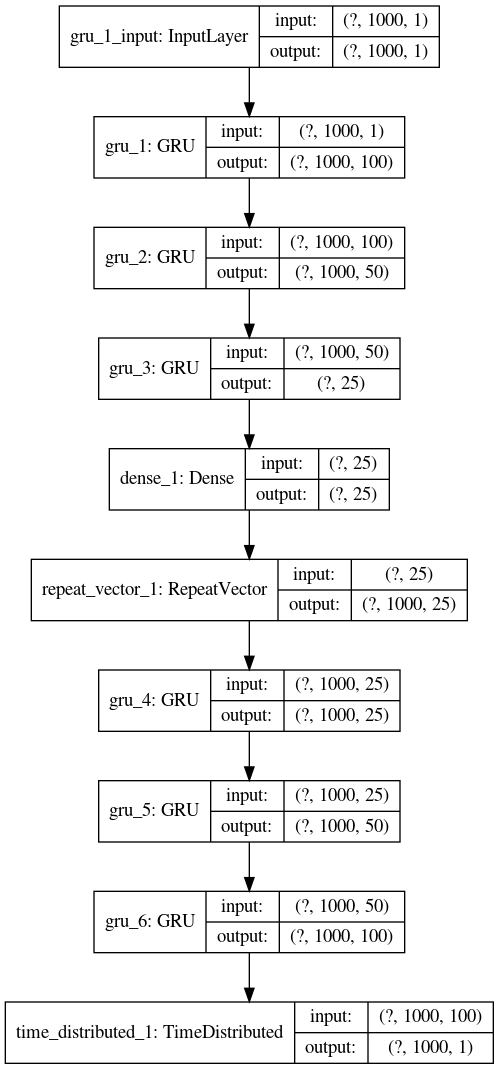

In [14]:
plot_model(deep_model, show_shapes=True)

In [82]:
import pickle
from scipy.stats import zscore

with open('for_snuffy/series_43023_500.pkl', 'rb') as f:
    segments = pickle.load(f)
    
with open('for_snuffy/series_43023_500_ids.pkl', 'rb') as f:
    seg_ids = pickle.load(f)
    
segments = zscore(segments)

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import CuDNNGRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
np.random.seed(seed=11)

deep_model = Sequential(name="LSTM-autoencoder")
deep_model.add(GRU(80, input_shape=(500,1),reset_after=True, return_sequences=False, recurrent_activation='sigmoid'))
deep_model.add(Dense(20, activation=None))
deep_model.add(RepeatVector(500))
deep_model.add(GRU(80, return_sequences=True,reset_after=True, recurrent_activation='sigmoid'))
deep_model.add(TimeDistributed(Dense(1)))


In [ ]:
encoder_inputs = Input(shape=(None, 100))
encoder = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru = GRU(latent_dim, return_sequences=True)
decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [260]:
deep_model.summary()

Model: "LSTM-autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               30600     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1000, 20)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1000, 100)         36300     
_________________________________________________________________
time_distributed (TimeDistri (None, 1000, 1)           101       
Total params: 69,021
Trainable params: 69,021
Non-trainable params: 0
_________________________________________________________________


In [85]:
deep_model.load_weights('lstm_autoencoder_2020-01-14_17-50-32.h5')

In [92]:
reco = deep_model.predict(np.reshape(segments[:20], (20,500,1)).astype(np.float32))

In [107]:
mse= np.mean((reco-np.reshape(segments[:20], (20,500,1)).astype(np.float32))**2)

In [108]:
mse

0.057424232

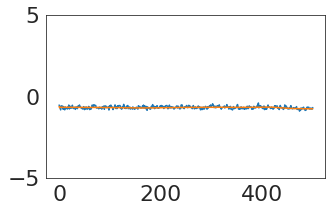

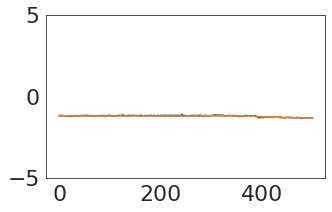

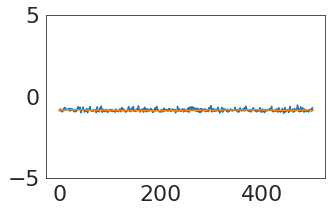

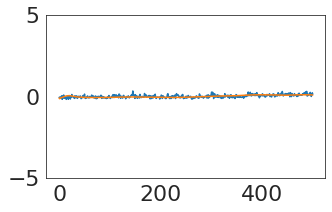

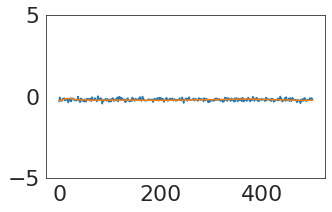

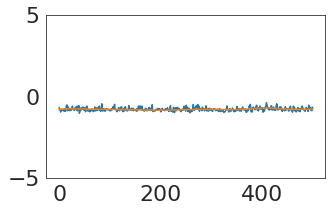

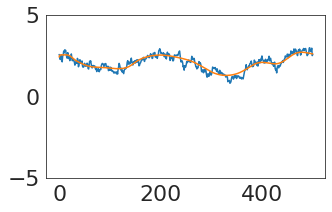

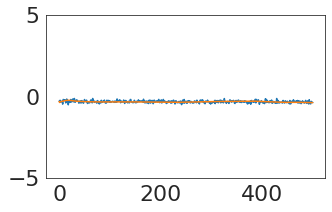

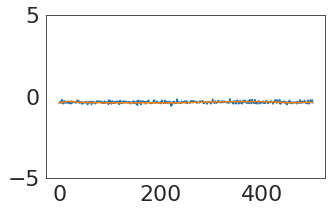

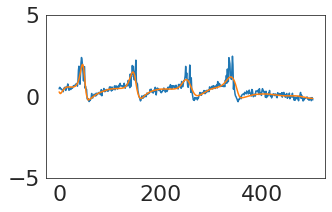

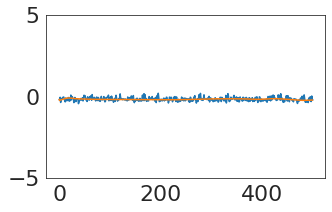

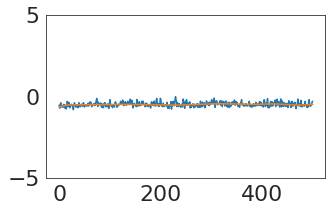

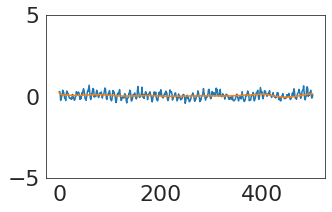

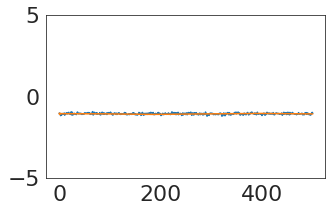

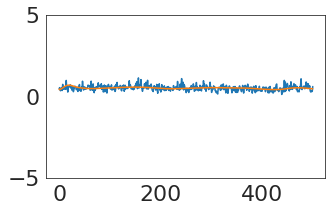

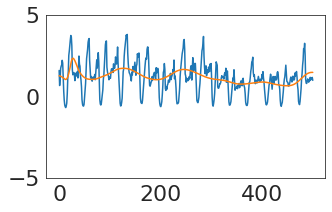

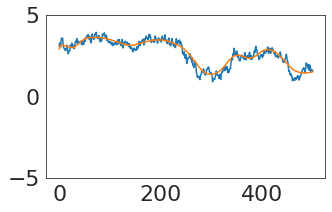

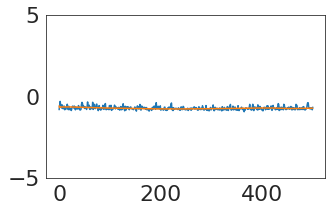

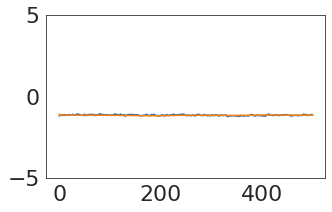

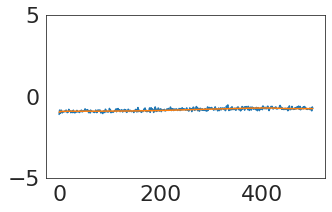

In [111]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 3.0)
for lc_index, lc in enumerate(reco):
    plt.ylim([-5,5])
    plt.plot(segments[lc_index])
    plt.plot(lc)
    plt.show()

In [87]:
deep_model.layers[:2]

In [88]:
encoded_segments = np.zeros((len(segments), 20), dtype=np.float32)

encoder = Sequential(deep_model.layers[:2])

for seg_index, segment in enumerate(segments):
    code = encoder.predict(np.reshape(segment, (1,500,1)).astype(np.float32))
    encoded_segments[seg_index] = code
    print(seg_index+1, "/", len(segments))
    clear_output(wait=True)

43023 / 43023


In [18]:
encoder = Sequential(deep_model.layers[:5])

In [81]:
np.sqrt(0.08238)

0.2870191631233009

In [89]:
with open('encoded_segments_weights_2020-01-14_17-50-32_series_43023_500.pkl', 'wb') as f:
    pickle.dump(encoded_segments, f)

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(encoded_segments)
transformed_encoded = pca.transform(encoded_segments)

In [37]:
pca.explained_variance_ratio_

array([0.37331215, 0.310116  , 0.05909716], dtype=float32)

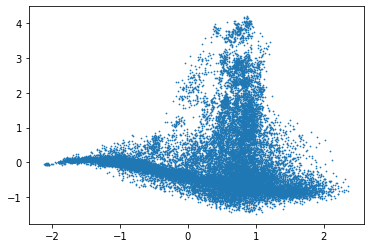

In [39]:

plt.scatter(transformed_encoded[:,0], transformed_encoded[:,1], s=0.5)
plt.show()

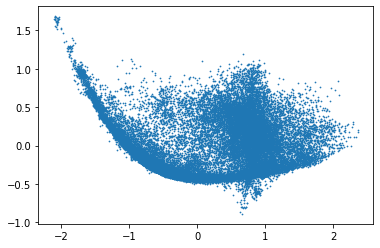

In [40]:
plt.scatter(transformed_encoded[:,0], transformed_encoded[:,2], s=0.5)
plt.show()

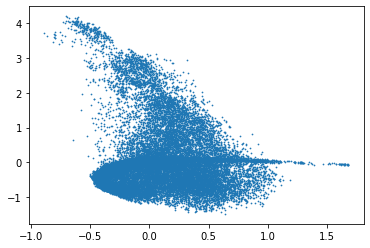

In [41]:
plt.scatter(transformed_encoded[:,2], transformed_encoded[:,1], s=0.5)
plt.show()

In [3]:
with open('encoded_segments_2019-12-18_11-48-01_weights.pkl', 'rb') as f:
    encoded_segments = pickle.load(f)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=2).fit_transform(encoded_segments)

In [ ]:
plt.plot(X_embedded[:,0], X_embedded[:,1])  # perplexity=2
plt.show()

In [4]:
import umap

embedding = umap.UMAP(metric='correlation').fit_transform(encoded_segments)

/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for hel

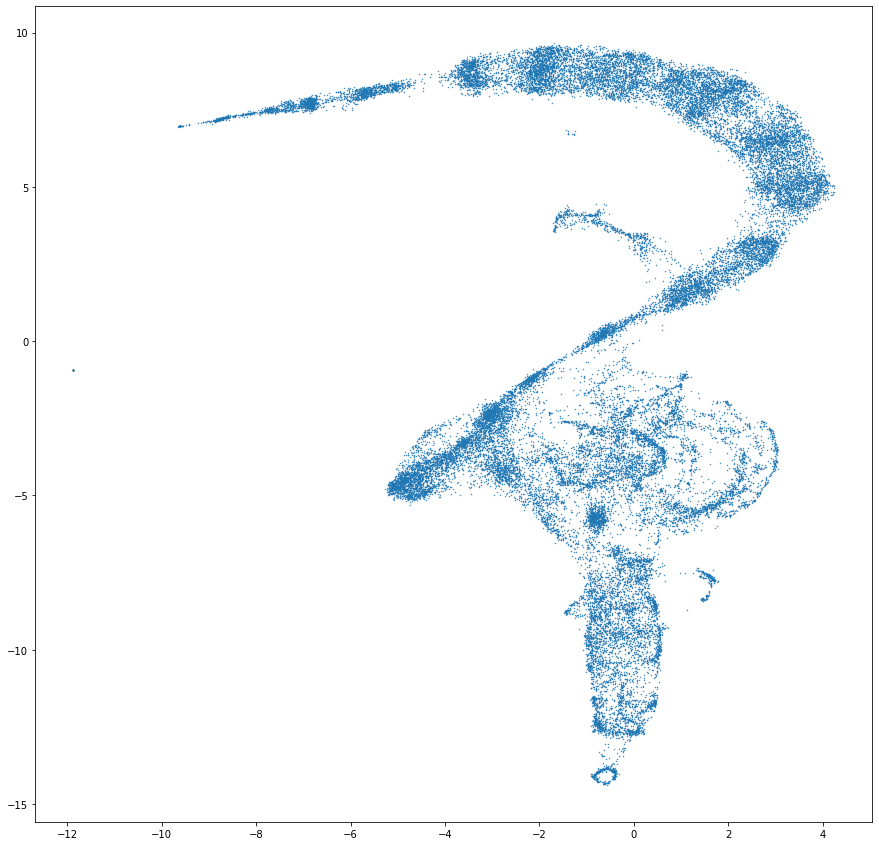

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.scatter(embedding[:,0], embedding[:,1], s=0.2)

In [11]:
embedding = umap.UMAP(n_neighbors=100,
                      min_dist=0.2,
                      metric='correlation').fit_transform(encoded_segments)

/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


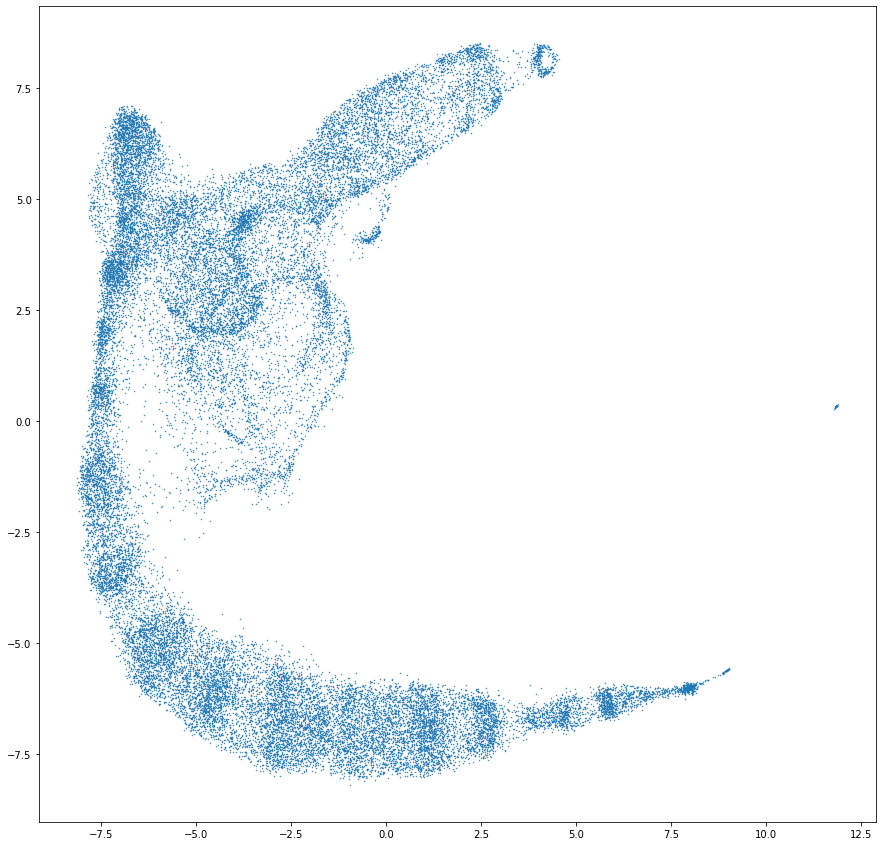

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.scatter(embedding[:,0], embedding[:,1], s=0.2)

In [6]:
import umap
embedding = umap.UMAP(n_neighbors=1000,
                      min_dist=0.3,
                      metric='correlation').fit_transform(encoded_segments)

/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for hel

In [9]:
paper_obIDs = np.loadtxt("Belloni_Altamirano_obsIDs.txt", dtype=str)

In [10]:
paper_obIDs

array(['10408-01-01-01', '10408-01-03-00', '10408-01-04-00',
       '10408-01-05-00', '10408-01-06-00', '10408-01-07-00',
       '10258-01-10-00', '20186-03-01-03', '20186-03-01-04',
       '20402-01-38-00', '20402-01-39-00', '20402-01-39-02',
       '20402-01-41-02', '20402-01-54-00', '20402-01-55-00',
       '20402-01-56-00', '20402-01-57-01', '20402-01-58-01',
       '20402-01-60-00', '30703-01-01-00', '30402-01-01-00',
       '40403-01-06-00', '40703-01-12-00', '40403-01-07-00',
       '40703-01-13-01', '40703-01-26-00', '40703-01-28-00',
       '40703-01-28-02', '40703-01-29-00', '40703-01-29-01',
       '40703-01-29-02', '40703-01-31-00', '50703-01-10-02',
       '50703-01-60-03', '50703-01-61-01', '60701-01-09-00',
       '70702-01-55-00', '80701-01-28-00', '80701-01-28-01',
       '80701-01-28-02', '80127-04-02-00', '80701-01-31-00',
       '90105-08-02-00', '90701-01-38-00', '91701-01-12-00',
       '91701-01-12-01', '92092-03-01-00', '93701-01-01-00',
       '93701-01-06-00',

In [232]:
qpo_colours = []

for seg_id in seg_ids:
    if seg_id.split("_")[0] in paper_obIDs:
        qpo_colours.append("red")
    else:
        qpo_colours.append("grey")
        

In [233]:
qpo_labels = []

for seg_id in seg_ids:
    if seg_id.split("_")[0] in paper_obIDs:
        qpo_labels.append("QPO")
    else:
        qpo_labels.append("other")
        

In [ ]:
qpo_scales = []

for seg_id in seg_ids:
    if seg_id.split("_")[0] in paper_obIDs:
        qpo_scales.append("QPO")
    else:
        qpo_scales.append("other")
        

In [21]:
seg_id.split("_")[0]

'40116-01-06-00'

In [27]:
"10408-01-01-01_13".split("_")[0] in paper_obIDs

True

In [39]:
len(paper_obIDs)

51

In [37]:
xxx = [seg.split("_")[0] for seg in seg_ids]

In [160]:
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_colour = []
for ob in xxx:
    if ob in ob_state:
        class_colour.append(np.where(classes == ob_state[ob])[0][0])
    else:
        class_colour.append(15)

In [155]:
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
class_name = []
for ob in xxx:
    if ob in ob_state:
        class_name.append(ob_state[ob])
        scales.append(5)
    else:
        class_name.append("Unknown")
        scales.append(0.1)

In [81]:
from matplotlib import cm
cm.get_cmap(plt.get_cmap("Set1"))

In [38]:
count=0
for i in paper_obIDs:
    if i in xxx:
        count+=1
        
count

49

In [206]:
import matplotlib.colors as mcolors
colours = mcolors.CSS4_COLORS.items()
colours_tuple = tuple(colours)

In [225]:
# colours = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
colours = ['#ffd8b1', '#000075', '#808080', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#000000']

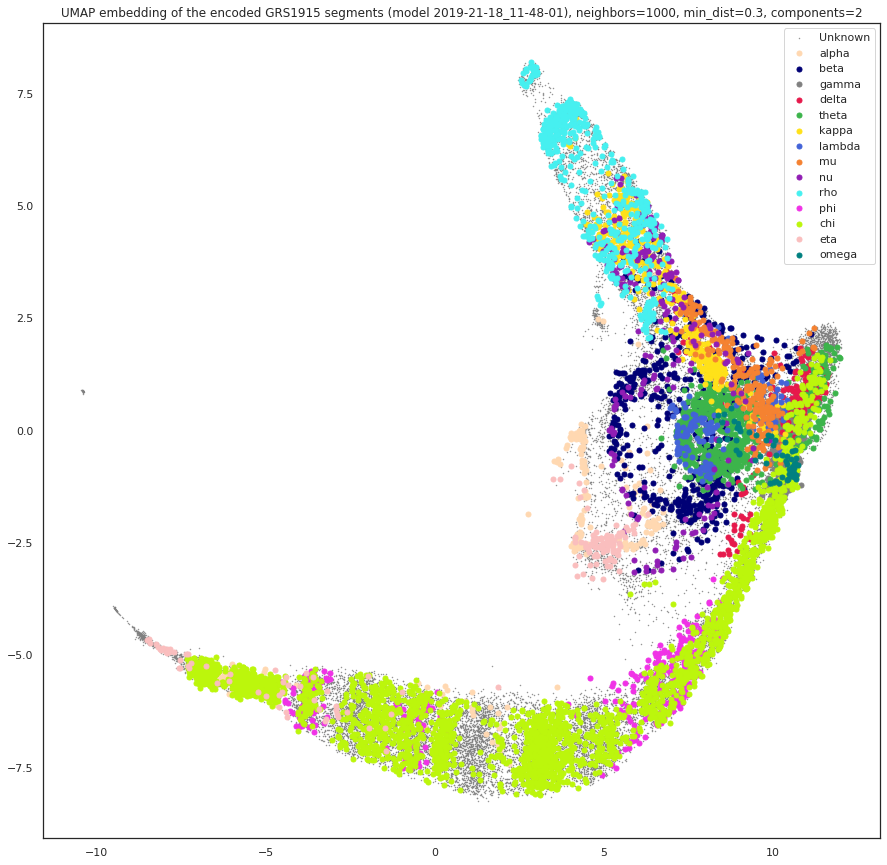

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 22})

# fig, ax = plt.subplots()
class_indices = np.where(np.array(class_name) == "Unknown")[0]
class_data = embedding[class_indices]

plt.scatter(class_data[:,0], class_data[:,1], s = 0.2, c="grey", label="Unknown")

for plot_class_ind, plot_class in enumerate(classes):
    class_indices = np.where(np.array(class_name) == plot_class)[0]
    class_data = embedding[class_indices]
    
    plt.scatter(class_data[:,0], class_data[:,1], s = 25, c=colours[plot_class_ind], label=plot_class)
    
plt.legend()
plt.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)

# scatter = ax.scatter(embedding[:,0], embedding[:,1], s=scales, c=class_colour, label= class_name)
#ax.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Classes")
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper left", title="Classes")
# plt.savefig("umap_on_features_2019-12-18_11-48-01.png")
plt.show()

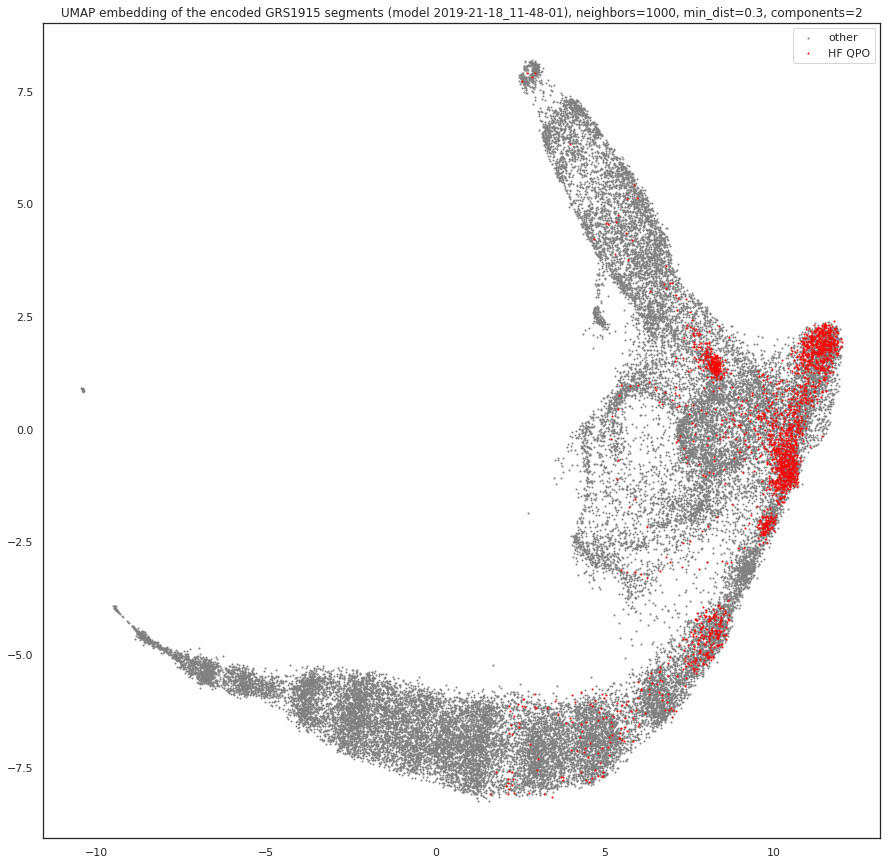

In [238]:
redint = np.where(np.array(qpo_colours) == "red")
greyint= np.where(np.array(qpo_colours) != "red")
plt.scatter(embedding[:,0][greyint], embedding[:,1][greyint], s=1, c="grey", label= "other")
plt.scatter(embedding[:,0][redint], embedding[:,1][redint], s=1, c="red", label= "HF QPO")
plt.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)
plt.legend()
plt.savefig("Belloni_Altamirano_2013_embedded.png")
plt.show()

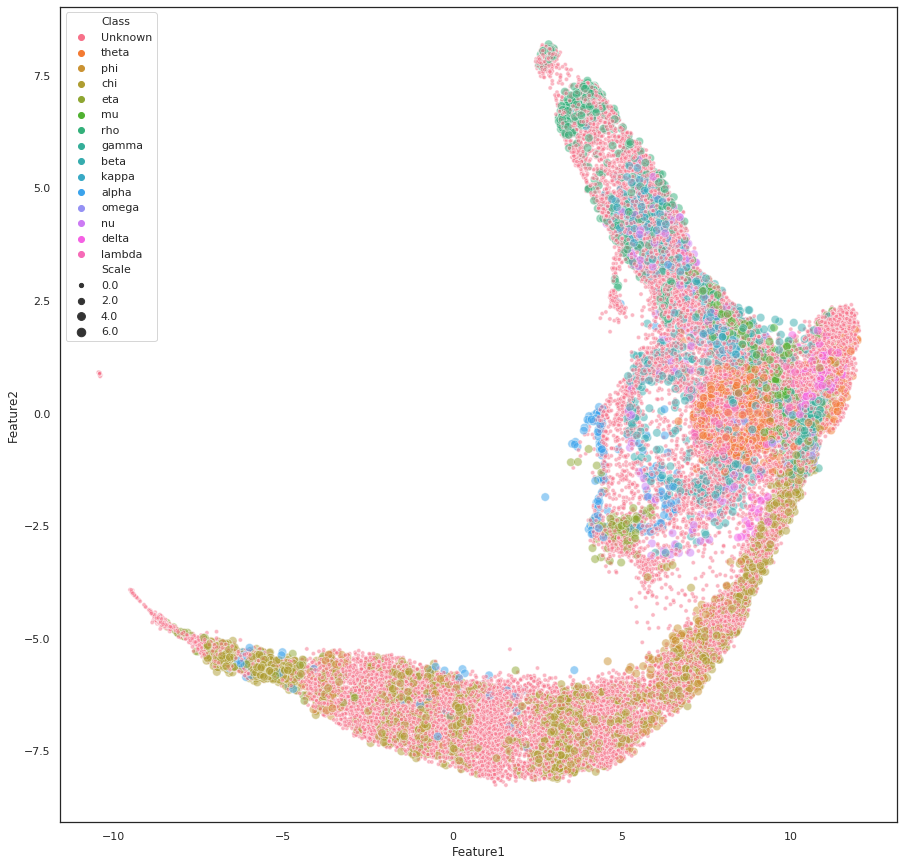

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 22})

# fig, ax = plt.subplots()



# scatter = ax.scatter(embedding[:,0], embedding[:,1], s=scales, c=class_colour, cmap=plt.get_cmap("Set1"), label= class_name)
# #ax.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper left", title="Classes")
# # plt.savefig("Belloni_Altamirano_2013_embedded.png")
# plt.show()

data = pd.DataFrame({"Feature1":embedding[:,0],"Feature2":embedding[:,1],"Class":class_name, "Scale": scales})
ax = sns.scatterplot(x="Feature1", y="Feature2", hue="Class", data=data, size="Scale", legend="brief", alpha=0.5)

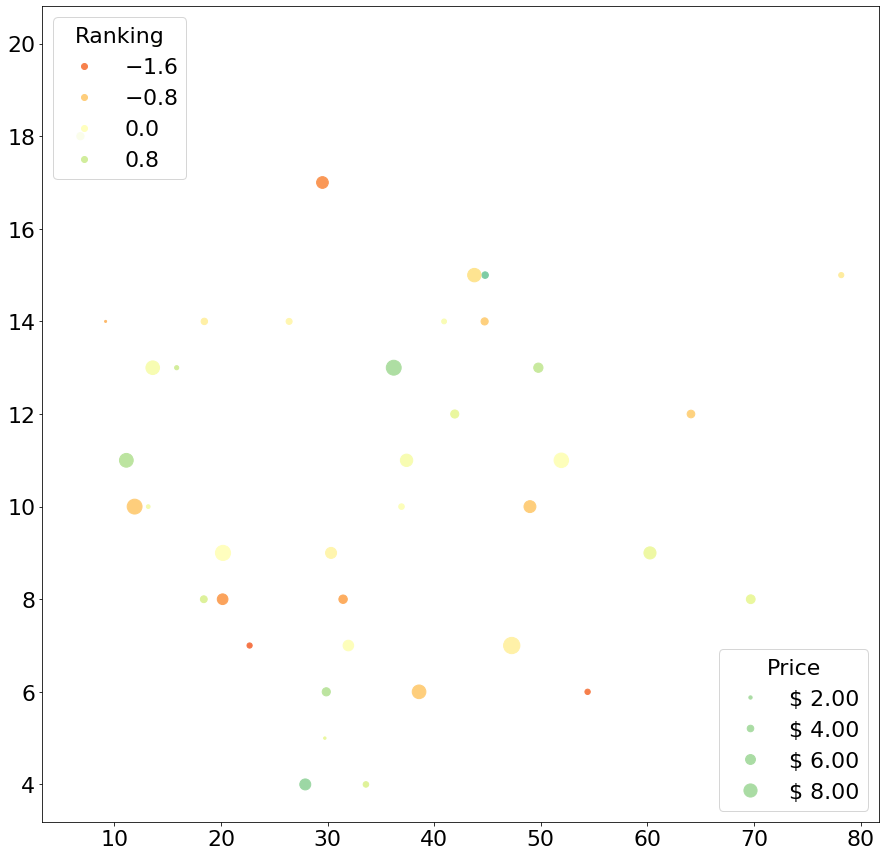

In [121]:
volume = np.random.rayleigh(27, size=40)
amount = np.random.poisson(10, size=40)
ranking = np.random.normal(size=40)
price = np.random.uniform(1, 10, size=40)

fig, ax = plt.subplots()

# Because the price is much too small when being provided as size for ``s``,
# we normalize it to some useful point sizes, s=0.3*(price*3)**2
scatter = ax.scatter(volume, amount, c=ranking, s=0.3*(price*3)**2,
                     vmin=-3, vmax=3, cmap="Spectral")

# Produce a legend for the ranking (colors). Even though there are 40 different
# rankings, we only want to show 5 of them in the legend.
legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="upper left", title="Ranking")
ax.add_artist(legend1)

# Produce a legend for the price (sizes). Because we want to show the prices
# in dollars, we use the *func* argument to supply the inverse of the function
# used to calculate the sizes from above. The *fmt* ensures to show the price
# in dollars. Note how we target at 5 elements here, but obtain only 4 in the
# created legend due to the automatic round prices that are chosen for us.
kw = dict(prop="sizes", num=5, color=scatter.cmap(0.7), fmt="$ {x:.2f}",
          func=lambda s: np.sqrt(s/.3)/3)
legend2 = ax.legend(*scatter.legend_elements(**kw),
                    loc="lower right", title="Price")

plt.show()

In [103]:
class_name

['Unknown',
 'Unknown',
 'Unknown',
 'theta',
 'phi',
 'chi1',
 'Unknown',
 'Unknown',
 'eta',
 'Unknown',
 'chi2',
 'chi4',
 'Unknown',
 'Unknown',
 'chi1',
 'chi1',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'mu',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'chi3',
 'rho',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'chi2',
 'Unknown',
 'phi',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'gamma',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'beta',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'mu',
 'gamma',
 'rho',
 'kappa',
 'Unknown',
 'Unknown',
 'chi1',
 'Unknown',
 'Unknown',
 'Unknown',
 'chi1',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'gamma',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 '

In [28]:
embedding[[43, 457,  2019,  3654,  4998,  5980,  6140, 10157, 11274,
        11575, 12409, 12509, 14505, 14517, 14732, 14985, 15435, 15654,
        16962, 17461, 18327, 20288, 22816, 23428, 24234, 24984, 25277,
        27659, 28005, 30302, 31404, 33927, 34283]]

array([[-11.526635 ,   1.8713175],
       [-11.519357 ,   1.8644352],
       [-11.514196 ,   1.8457409],
       [-11.523595 ,   1.8698835],
       [-11.523269 ,   1.8698343],
       [-11.516806 ,   1.8600688],
       [-11.527672 ,   1.873804 ],
       [-11.516546 ,   1.8795195],
       [-11.556038 ,   1.9020844],
       [-11.523613 ,   1.8659941],
       [-11.520459 ,   1.866003 ],
       [-11.526368 ,   1.872886 ],
       [-11.525614 ,   1.8724091],
       [-11.513006 ,   1.8592855],
       [-11.527132 ,   1.8736084],
       [-11.518953 ,   1.8611484],
       [-11.52409  ,   1.8701606],
       [-11.524    ,   1.8708031],
       [-11.528364 ,   1.8742275],
       [-11.506189 ,   1.8475363],
       [-11.520778 ,   1.8676269],
       [-11.517159 ,   1.8528413],
       [-11.50646  ,   1.8240663],
       [-11.524603 ,   1.8715304],
       [-11.519468 ,   1.8639137],
       [-11.520718 ,   1.8666096],
       [-11.5258875,   1.8711436],
       [-11.528583 ,   1.8750304],
       [-11.527761 ,

In [67]:
bottom_bit = np.where(embedding[:,1] < -7.5)

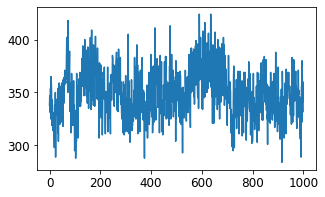

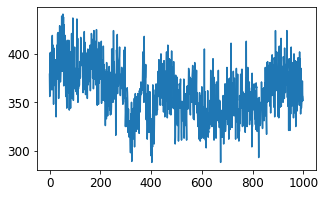

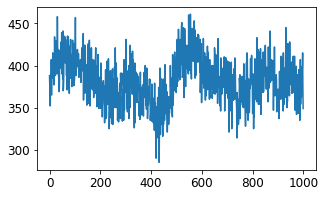

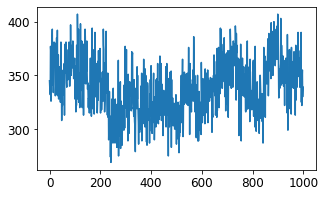

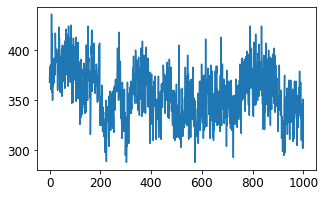

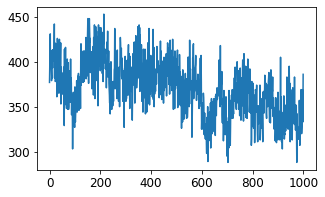

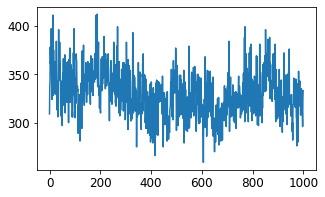

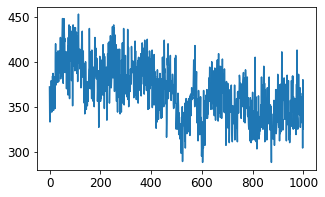

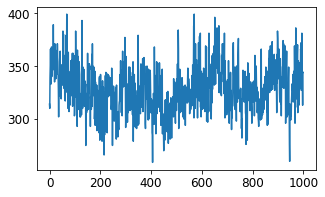

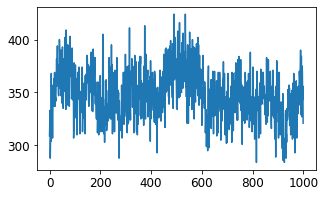

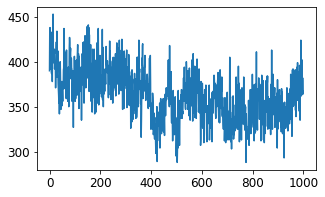

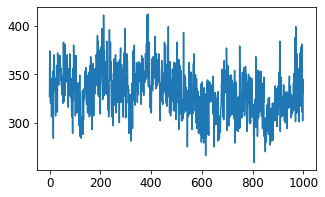

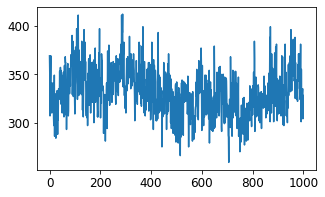

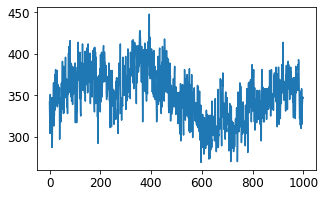

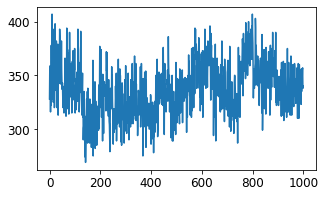

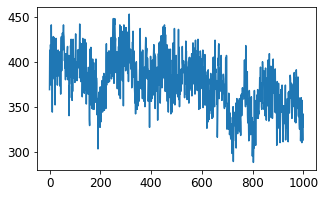

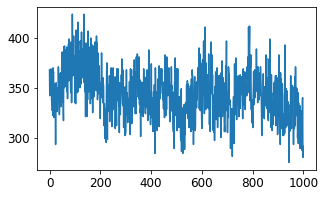

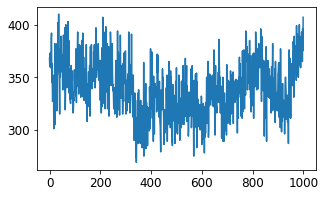

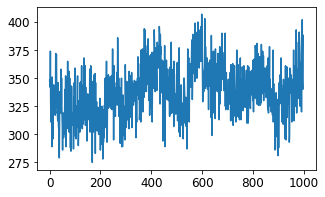

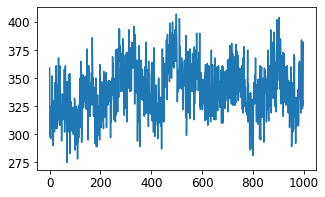

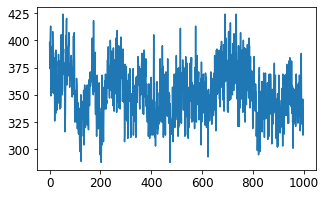

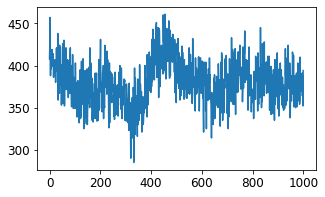

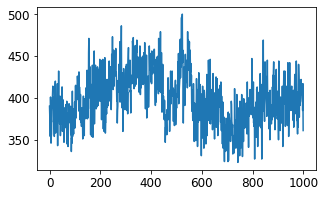

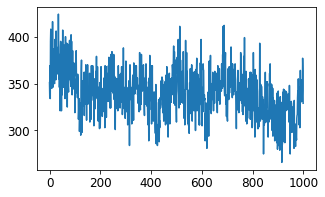

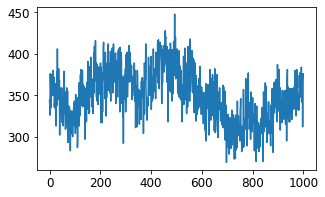

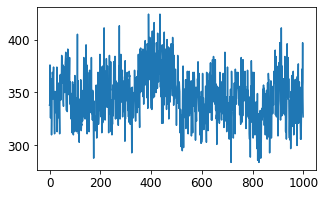

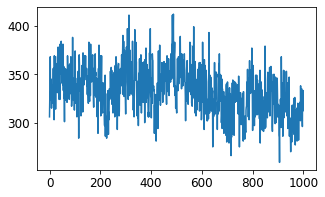

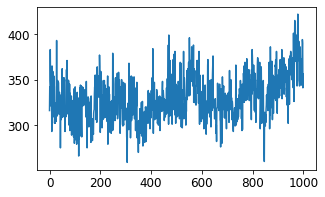

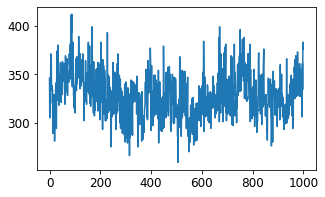

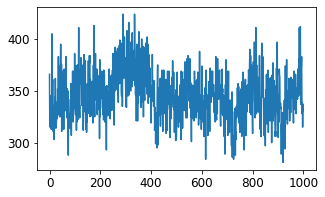

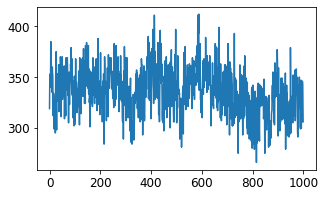

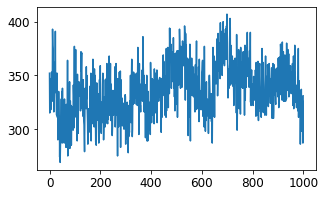

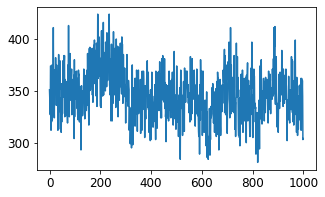

In [73]:
plt.rcParams['figure.figsize'] = (5.0, 3.0)
plt.rcParams.update({'font.size': 12})
for lc in enumerate(segments[left_cluster[:30]]):
    plt.plot((lc[1]).flatten())
    plt.show()

In [27]:
[x.split("_")[0] for x in np.asarray(seg_ids)[[43, 457,  2019,  3654,  4998,  5980,  6140, 10157, 11274,
        11575, 12409, 12509, 14505, 14517, 14732, 14985, 15435, 15654,
        16962, 17461, 18327, 20288, 22816, 23428, 24234, 24984, 25277,
        27659, 28005, 30302, 31404, 33927, 34283]]]

['93701-01-20-00',
 '93701-01-20-00',
 '93701-01-38-00',
 '93701-01-26-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-01',
 '93701-01-26-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-26-00',
 '93701-01-26-00',
 '93701-01-26-00',
 '93701-01-20-00',
 '93701-01-38-00',
 '80701-01-36-00',
 '93701-01-20-00',
 '93701-01-20-01',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-20-00',
 '93701-01-26-00',
 '93701-01-20-00']

In [35]:
ids=[x.split("_")[0] for x in seg_ids]
np.where((np.asarray(ids) == "93701-01-38-00"))

(array([ 2019, 20288]),)

In [44]:
len(top_cluster)

536

In [61]:
len(left_cluster[0])

33

In [63]:
np.asarray(ids)[left_cluster]

array(['93701-01-20-00', '93701-01-20-00', '93701-01-38-00',
       '93701-01-26-00', '93701-01-20-00', '93701-01-20-00',
       '93701-01-20-00', '93701-01-20-00', '93701-01-20-00',
       '93701-01-20-00', '93701-01-20-00', '93701-01-20-00',
       '93701-01-20-00', '93701-01-20-01', '93701-01-26-00',
       '93701-01-20-00', '93701-01-20-00', '93701-01-26-00',
       '93701-01-26-00', '93701-01-26-00', '93701-01-20-00',
       '93701-01-38-00', '80701-01-36-00', '93701-01-20-00',
       '93701-01-20-01', '93701-01-20-00', '93701-01-20-00',
       '93701-01-20-00', '93701-01-20-00', '93701-01-20-00',
       '93701-01-20-00', '93701-01-26-00', '93701-01-20-00'], dtype='<U15')

In [51]:
n=7

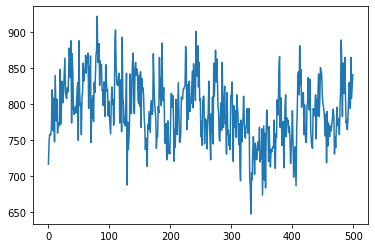

In [63]:
plt.plot(segments[n])
n+=1

In [16]:
for seg in seg_ids:
    print(ob_state[seg])

KeyError: '40116-01-03-01'

In [40]:
len(seg_ids)

1752

In [90]:
import umap

embedding = umap.UMAP(metric='correlation').fit_transform(encoded_segments)

/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/ae-env/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/jakub/anaconda3/envs/ae-env/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for hel

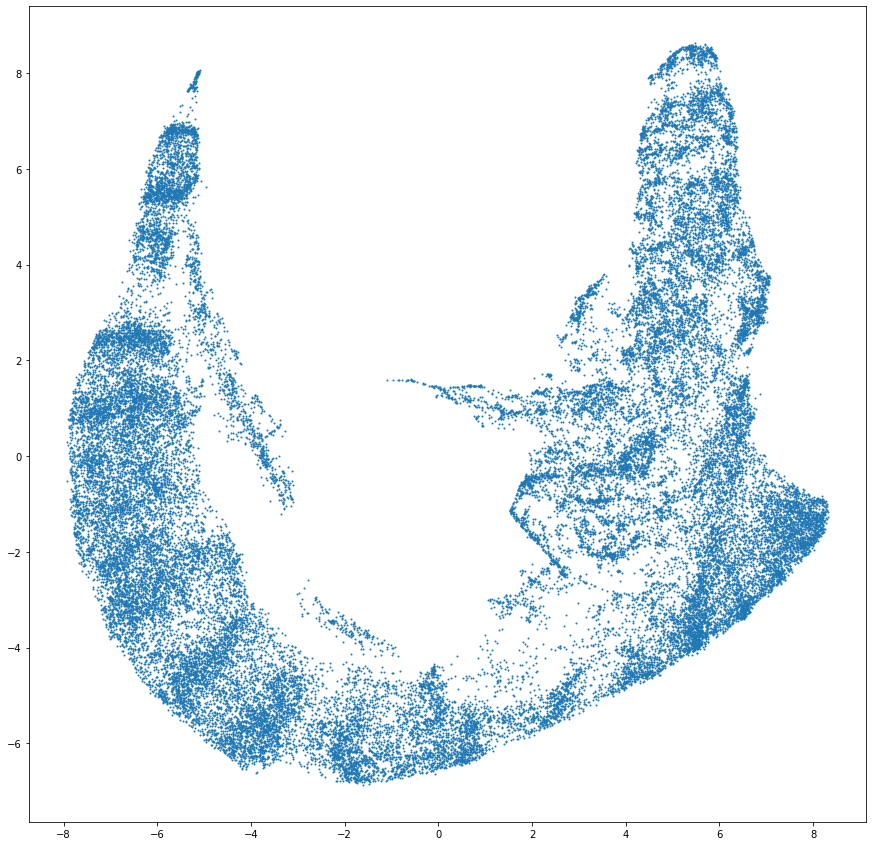

In [94]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.scatter(embedding[:,0], embedding[:,1], s=1)

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 22})

# fig, ax = plt.subplots()
class_indices = np.where(np.array(class_name) == "Unknown")[0]
class_data = embedding[class_indices]

plt.scatter(class_data[:,0], class_data[:,1], s = 0.2, c="grey", label="Unknown")

for plot_class_ind, plot_class in enumerate(classes):
    class_indices = np.where(np.array(class_name) == plot_class)[0]
    class_data = embedding[class_indices]
    
    plt.scatter(class_data[:,0], class_data[:,1], s = 25, c=colours[plot_class_ind], label=plot_class)
    
plt.legend()
#plt.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)

# scatter = ax.scatter(embedding[:,0], embedding[:,1], s=scales, c=class_colour, label= class_name)
#ax.title("UMAP embedding of the encoded GRS1915 segments (model 2019-21-18_11-48-01), neighbors=1000, min_dist=0.3, components=2", fontsize=12)
# handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# legend2 = ax.legend(handles, labels, loc="upper right", title="Classes")
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper left", title="Classes")
#plt.savefig("umap_on_features_2019-12-18_11-48-01.png")
plt.show()

NameError: name 'class_name' is not defined

In [101]:
sec_count=0
for i in lcs:
    sec_count += len(i[0])

In [102]:
sec_count

5099757